# 04 - Applied Machine Learning

In [1]:
#imports and const
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import numpy as np
from sklearn import linear_model
import networkx as nx

DATAPATH = './'

## Question 1

In this first question our goal is to conclude about the results of a program which is supposed to increase earnings. Our data contains, for each person, it's skin color, if it is married, with a degree, its age, number of years of education and earnings for years 1974, 1975 (before program) and 1978. In the first part we will make a naive analysis by looking at the final revenues in each group : the treated group which received the program and the control group which didn't. After this first analysis which show no visible impact, we will analyse the distribution of other features to see if both group are similar, which is not the case. In order to compare the real efficiency of the program we will build a control group similar to the treated group:

First we will train a model which give us the probability that a certain row belong to the treated or control group. Then we will try to match each row of the treated group with a row of the control group, by using the closest propensity score, here the closest difference between probability of being in the treated group (we use the networkx library to ease our work) This give us a better result, however we can see that some categorical data are not really the same, for example the rate of black people in each group, so we will try to match again the rows by matching also categorical data, this will reduce the size of each group because we add some constrains. Finally we will study again the efficiency of our program with the new built groups.

### 1. A naive analysis

In this first question we just analyse the results associated with the column `re78` by group without any further analysis

First, let's load the data

In [2]:
df_lalonde_ori  = pd.read_csv(os.path.join(DATAPATH,"lalonde.csv"))

df_lalonde_ori.head(10) # There are 614 rows and 11 columns

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700


We will then split the dataFrame between the treatment and the control groups, we will use the treat column as our filter.
To have a first idea of our data, we will look at the description of each dataframe

In [3]:
df_treat = df_lalonde_ori.loc[df_lalonde_ori["treat"]==1]
df_control = df_lalonde_ori.loc[df_lalonde_ori["treat"]==0]
df_treat.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [4]:
df_control.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


We can see some interesting facts : 
* There are 185 subjects in the treatment group and 429 in the control group
* For columns re74, re75, re78 which are earnings the minimal value is 0, which can be either a null earning or a missing data.
    
Let's compare some figures : 

In [5]:
treat_mean_78 = df_treat['re78'].mean()
control_mean_78 = df_control['re78'].mean() 
difference_mean_78 = control_mean_78 - treat_mean_78

treat_median_78 = df_treat['re78'].median()
control_median_78 = df_control['re78'].median() 
difference_median_78 = control_median_78 - treat_median_78
print(f"Mean of earnings in 1978 for treatment group : {treat_mean_78}")
print(f"Mean of earnings in 1978 for control group : {control_mean_78}")
print(f"Difference between both : {difference_mean_78} (which represents {100*difference_mean_78/treat_mean_78}% of treatment and , {100*difference_mean_78/control_mean_78}% of control)")
print('*'*10)
print(f"Median of earnings in 1978 for treatment group : {treat_median_78}")
print(f"Median of earnings in 1978 for control group : {control_median_78}")
print(f"Difference between both : {difference_median_78} (which represents {100*difference_median_78/treat_median_78}% of treatment and , {100*difference_median_78/control_median_78}% of control)")

Mean of earnings in 1978 for treatment group : 6349.143530270269
Mean of earnings in 1978 for control group : 6984.169742307697
Difference between both : 635.0262120374273 (which represents 10.001761796844994% of treatment and , 9.0923650980396% of control)
**********
Median of earnings in 1978 for treatment group : 4232.309
Median of earnings in 1978 for control group : 4975.505
Difference between both : 743.1959999999999 (which represents 17.560060005070515% of treatment and , 14.937096837406452% of control)


With this first figures it seems that the treatment is useless because both the median and the mean revenue are significantly higher for the control group

Let's show the plots associated to these figures :

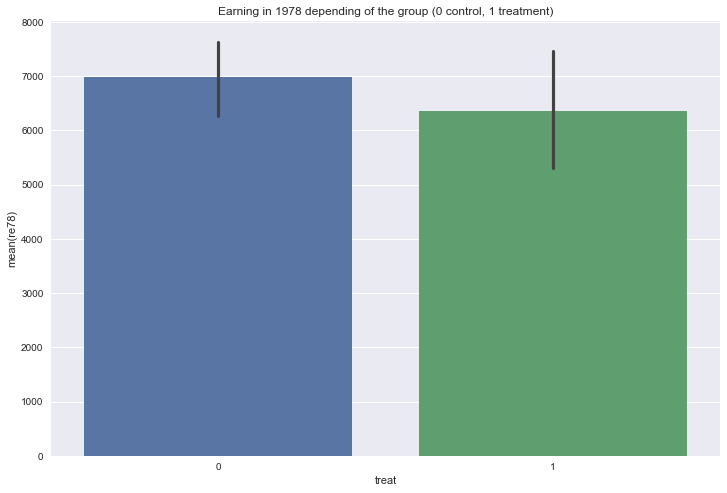

In [6]:
#First let's make a classic barplot
sb.set(style="darkgrid")
zone, plot = plt.subplots(ncols=1, sharey=True)
zone.set_size_inches(12, 8)
plot = sb.barplot(x="treat", y="re78", data=df_lalonde_ori.sort_values(["treat"],ascending=True))
plot.set_title("Earning in 1978 depending of the group (0 control, 1 treatment)")

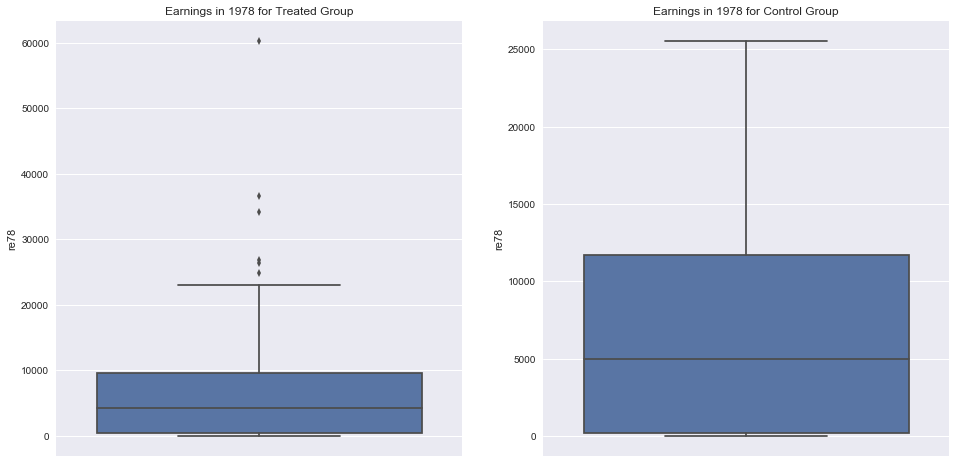

In [7]:
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 8)

plot1 = sb.boxplot(y = 're78' , data=df_treat, ax = plot1)
plot1.set_title("Earnings in 1978 for Treated Group")

plot2 = sb.boxplot(y = 're78' , data=df_control, ax = plot2)
plot2.set_title("Earnings in 1978 for Control Group")

It seems there are some outliers and that many values are equals to zero, to have a better understanding of the data we will use a swarmplot

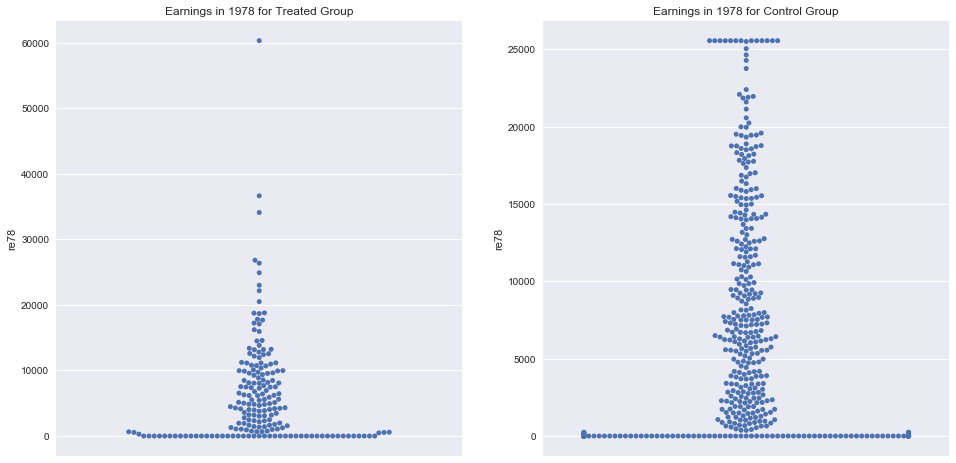

In [8]:
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 8)

plot1 = sb.swarmplot(y = 're78' , data=df_treat, ax = plot1)
plot1.set_title("Earnings in 1978 for Treated Group")

plot2 = sb.swarmplot(y = 're78' , data=df_control, ax = plot2)
plot2.set_title("Earnings in 1978 for Control Group")

If we remove the outliers we obtain these figures and plots (it's still similar, but the scales are closer)
We don't want to remove the values equal to zero as they represent people without a job, which is very meaningul in our studycase

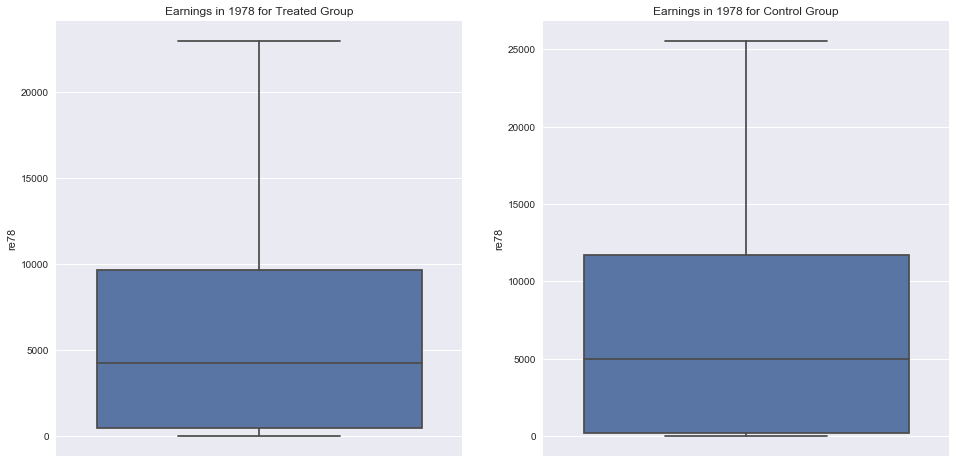

In [9]:
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 8)
plot1 = sb.boxplot(y = 're78' , data=df_treat, ax = plot1, showfliers=False)
plot1.set_title("Earnings in 1978 for Treated Group")

plot2 = sb.boxplot(y = 're78' , data=df_control, ax = plot2, showfliers=False)
plot2.set_title("Earnings in 1978 for Control Group")

#### Conclusion of the naive analysis : 
* If we only look at the distribution of the `re78` variable, it seems that the treatment is not effective because both the mean and the median of the treated group are lower than those of the control group. This conclusion is still true when we remove zeros earning cases in both groups.


### 2. A closer look at the data

We will first plot the continous values (`age`, `educ`,`re74`,`re75`), each time we will make 2 boxplots (with and without outliers), one barplot (to have a quick overview), 2 distplots(to see the exact distribution and the estimated density) and we will show the description of each group. To make our work easier we will define two functions to do it.

In [10]:
def add_boxplot(yaxis,xaxis,title,df):
    zone, (plot1, plot2) = plt.subplots(ncols=2)
    zone.set_size_inches(16, 6)
    
    plot1 = sb.boxplot(y = yaxis ,x= xaxis, data=df, ax = plot1, showfliers=True)
    plot1.set_title(title)

    plot2 = sb.boxplot(y = yaxis ,x= xaxis, data=df, ax = plot2, showfliers=False)
    plot2.set_title(title+" without outliers")
    
    
def add_barplot(yaxis,xaxis,title,df):
    zone, plot = plt.subplots(ncols=1, sharey=True)
    zone.set_size_inches(8, 6)
    
    plot = sb.barplot(x=xaxis, y=yaxis, data=df)
    plot.set_title(title)
    
    
def add_displot(title,column):
    zone, (plot1, plot2) = plt.subplots(ncols=2)
    zone.set_size_inches(16, 6)
    
    plot1 = sb.distplot(df_control[column],kde=False, ax=plot1)
    plot1 = sb.distplot(df_treat[column],kde=False, ax=plot1)
    plot1.set_title(title)
    
    plot2 = sb.distplot(df_control[column], hist=False,ax=plot2)
    plot2 = sb.distplot(df_treat[column], hist=False,ax=plot2)
    plot2.set_title(title+" : estimated density")
    print("Control group is blue and treated group is green")
    
def show_description(column):
    mean_treated = df_treat[column].mean()
    median_treated = df_treat[column].median()
    mean_control = df_control[column].mean()
    median_control = df_control[column].median()
    print(f'Mean for treated group : {mean_treated}')
    print(f'Mean for control group : {mean_control}')
    print(f'Difference of mean: {mean_control-mean_treated}')
    print(f'Median for treated group : {median_treated}')
    print(f'Median for control group : {median_control}')
    print(f'Difference of median: {median_control-median_treated}')
    
def add_everything(column,desc):
    show_description(column)
    add_boxplot(column,"treat",desc+" based on the group",df_lalonde_ori)
    add_barplot(column,"treat",desc+" based on the group",df_lalonde_ori.sort_values([column],ascending=True))
    add_displot(f"Distribution of {desc} depending on the group",column)

**Age : **

Mean for treated group : 25.816216216216215
Mean for control group : 28.03030303030303
Difference of mean: 2.2140868140868157
Median for treated group : 25.0
Median for control group : 25.0
Difference of median: 0.0
Control group is blue and treated group is green


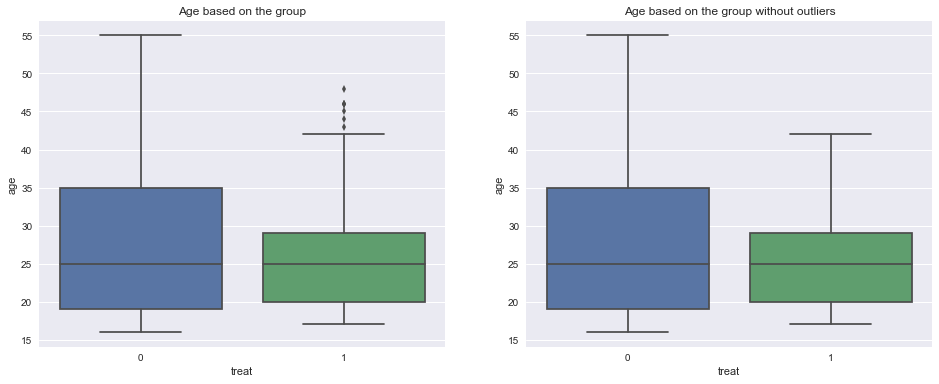

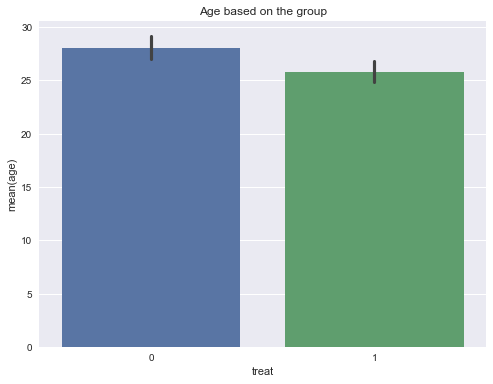

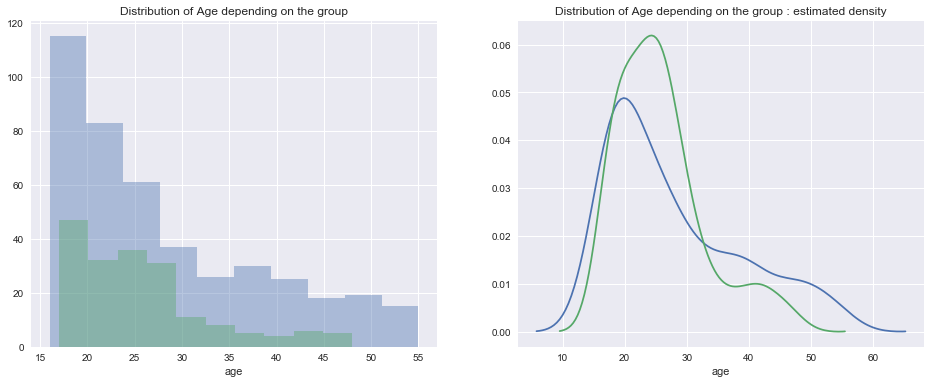

In [11]:
add_everything("age","Age")

The mean age for control group is slightly higher for the control group, even if the distribution is not so different between each group

**Education : **

Mean for treated group : 10.345945945945946
Mean for control group : 10.235431235431236
Difference of mean: -0.1105147105147104
Median for treated group : 11.0
Median for control group : 11.0
Difference of median: 0.0
Control group is blue and treated group is green


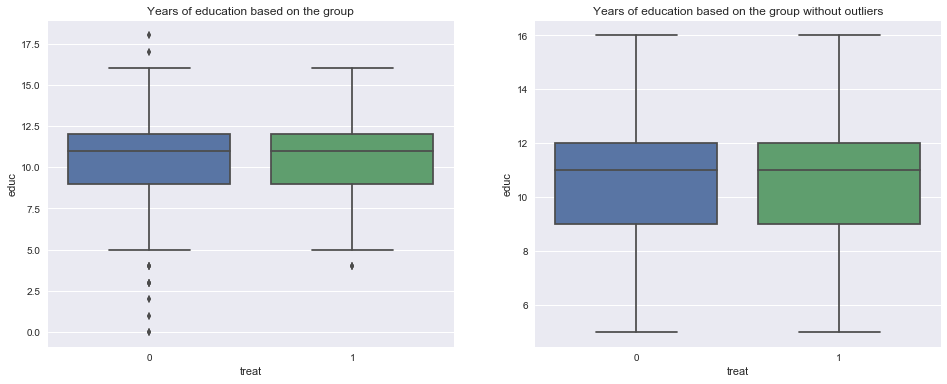

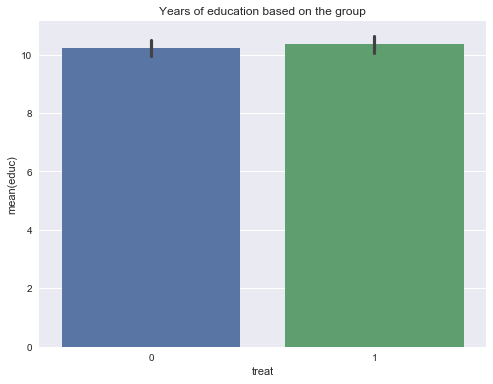

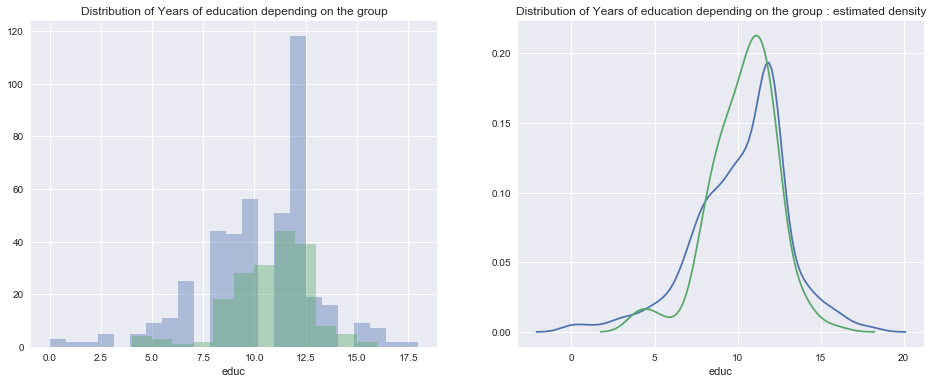

In [12]:
add_everything("educ","Years of education")

The number of years of education is quite similar between each group but there are some elements to notice:
* The majority of all people have between 10 and 13 years of education, that's why the mean is close
* The density for the treatment group is slightly to the left, meaning globally they have fewer years of education
* There are less high outliers for treatment group

** re74 :**

Mean for treated group : 2095.573688648649
Mean for control group : 5619.236506386947
Difference of mean: 3523.6628177382986
Median for treated group : 0.0
Median for control group : 2547.047
Difference of median: 2547.047
Control group is blue and treated group is green


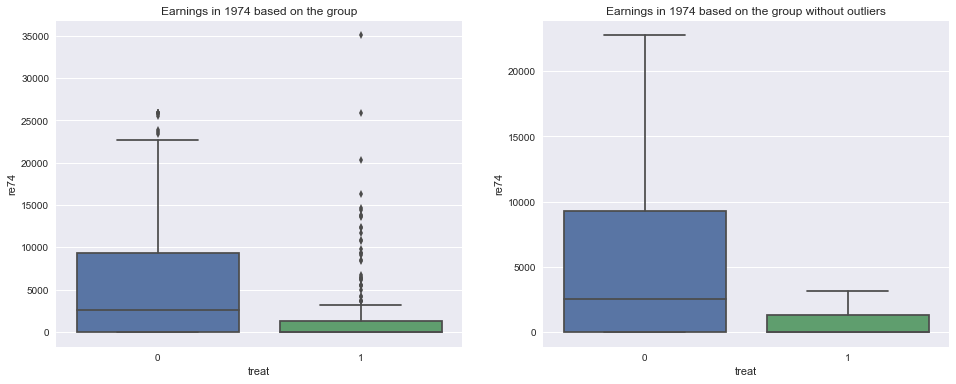

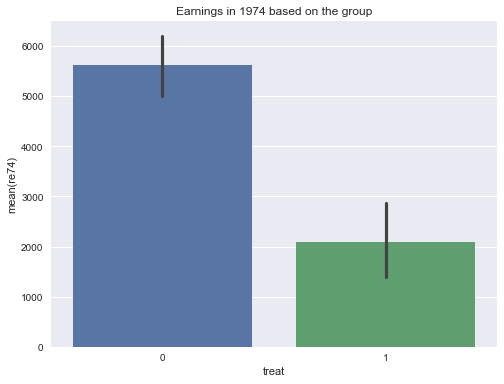

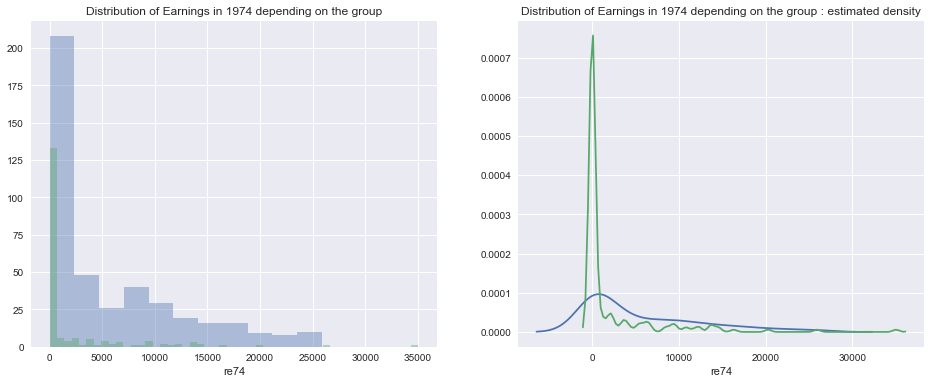

In [13]:
add_everything('re74',"Earnings in 1974")

We can notice a clear difference of mean between both groups, however there are a lot of people from the control with low earnings (or unemployment) aswell. 

** re75 : **

Mean for treated group : 1532.055313783784
Mean for control group : 2466.4844431235447
Difference of mean: 934.4291293397607
Median for treated group : 0.0
Median for control group : 1086.726
Difference of median: 1086.726
Control group is blue and treated group is green


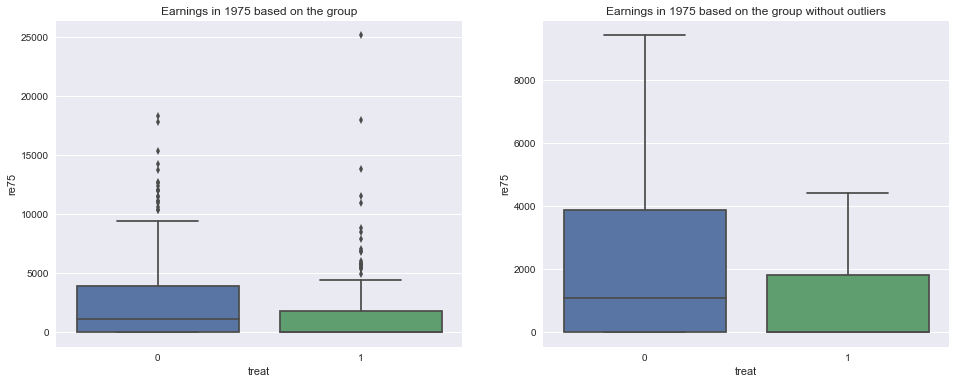

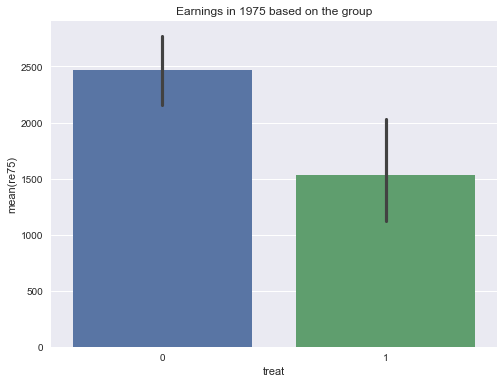

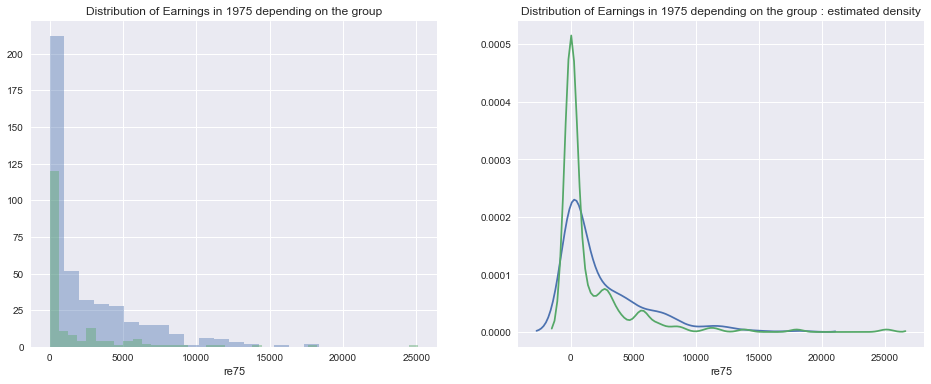

In [14]:
add_everything('re75',"Earnings in 1975")

The difference is still noticeable, even if it slightly less than for the previous year.

Globally, we can state than the continuous values for each group are **not** close, therefore our previous analysis is probably very wrong

For categorical data, we will print the number and the percentage for each group. 
We will only plot the percentage per group since it is not very representative to show the number (size of the groups are not equal)

In [15]:
def feature_analysis(dftot,population_treated,population_control,feature,desc,in_df=True,feature2=None):
    if in_df:
        df_feat = dftot.loc[dftot[feature]==1]
    #We add this condition to handle the case of categorical values with 3 values eg whith one of them not in the df
    # i.e:white people are people non black and non hispanic
    else : 
        df_nofeat_1 = dftot.loc[dftot[feature]==0]
        df_feat = df_nofeat_1[df_nofeat_1[feature2]==0]
    population_feature_treated = df_feat.loc[df_feat["treat"]==1].shape[0]
    population_feature_control = df_feat.loc[df_feat["treat"]==0].shape[0]
    percentage_feature_treated = 100*population_feature_treated/population_treated
    percentage_feature_control = 100*population_feature_control/population_control
    print(f'Total number of {desc} : {df_feat.shape[0]}')
    print(f'Number of {desc} in the treatment group : {population_feature_treated}, which represents {percentage_feature_treated}% of the treated group')
    print(f'Number of {desc} in the control group : {population_feature_control}, which represents {percentage_feature_control}% of the control group')
    print()
    return percentage_feature_treated,percentage_feature_control

def get_categorical_results(dftot,population_treated,population_control):
    #We define a dict wich associate each categorical value with a description
    associate_feature_desc = {"black":"Black people","hispan":"Hispanic people","white":"White people","married":"Married people","nodegree":"People without degree"}
    df_res = pd.DataFrame(columns=["Feature","Percentage treatment","Percentage control"])
    for key, value in associate_feature_desc.items(): 
        if key == "white":
            p_t,p_c = feature_analysis(dftot,population_treated,population_control,"black",value,in_df=False,feature2="hispan") 
        else:
            p_t,p_c = feature_analysis(dftot,population_treated,population_control,key,value)
        df_res.loc[df_res.shape[0]] = [key,p_t,p_c]
    return df_res

population_treated = df_treat.shape[0]
population_control = df_control.shape[0]

df_categorical = get_categorical_results(df_lalonde_ori,population_treated,population_control)
df_categorical

Total number of Black people : 243
Number of Black people in the treatment group : 156, which represents 84.32432432432432% of the treated group
Number of Black people in the control group : 87, which represents 20.27972027972028% of the control group

Total number of Hispanic people : 72
Number of Hispanic people in the treatment group : 11, which represents 5.945945945945946% of the treated group
Number of Hispanic people in the control group : 61, which represents 14.21911421911422% of the control group

Total number of White people : 299
Number of White people in the treatment group : 18, which represents 9.72972972972973% of the treated group
Number of White people in the control group : 281, which represents 65.5011655011655% of the control group

Total number of Married people : 255
Number of Married people in the treatment group : 35, which represents 18.91891891891892% of the treated group
Number of Married people in the control group : 220, which represents 51.282051282051285

,Feature,Percentage treatment,Percentage control
0,black,84.324324,20.279720
1,hispan,5.945946,14.219114
2,white,9.729730,65.501166
3,married,18.918919,51.282051
4,nodegree,70.810811,59.673660


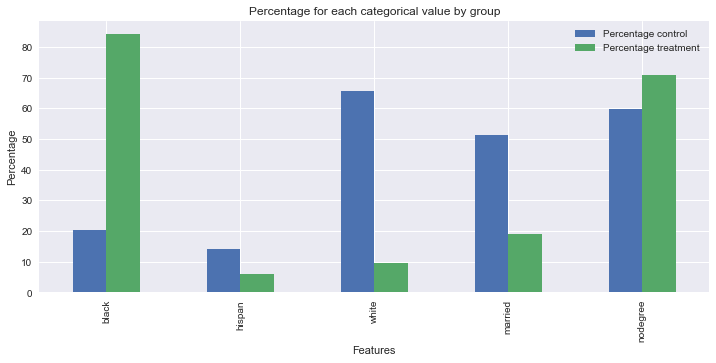

In [16]:
plot = df_categorical.plot.bar(y=["Percentage control","Percentage treatment"],x=["Feature"], figsize=(12,5))
plot.set_xlabel('Features');
plot.set_ylabel('Percentage');
plot.set_title('Percentage for each categorical value by group');

We can notice clear differences for each categorical data, either relative to the ethnicity, with the marital situation or the presence of degree. That shows that once again we should not compare both group in this situation

The figures and plots clearly show that we have to change the control group in order to be able to compare both groups and status about the efficiency of the treatment

### 3. A propensity score model

We will use propensity scores in order to adress this issue. In a first part we have to compute then, i.e. train a model that feat out data to attribute to each person the probability that it is in the treatment or control group

In [17]:
#First let's compute the model
df_prope = df_lalonde_ori.copy()
logistic = linear_model.LogisticRegression()
feature_cols = ["age","educ","black","hispan","married","nodegree","re74","re75"]
logistic.fit(df_prope[feature_cols],df_prope["treat"])
for f in range(len(feature_cols)):
    print("{0} * {1} + ".format(logistic.coef_[0][f], feature_cols[f]))
print(logistic.intercept_)

-0.006794203196110479 * age + 
-0.06602229032932304 * educ + 
2.584312591779158 * black + 
-0.04066538431557746 * hispan + 
-0.8414791177767145 * married + 
-0.36073074385840437 * nodegree + 
-7.541707841613298e-05 * re74 + 
5.759219439211685e-05 * re75 + 
[-0.63204745]


In [18]:
# Let's see our results
prop_scores = logistic.predict_proba(df_prope[feature_cols])
#This array contains the prediction for each data, let's add these data to our dataframe
# TODO : check and explain whi 0 is control and 1 is treatment
df_prope['Proba treatment'] = np.asarray(prop_scores).T[1]
df_prope['Proba control'] = np.asarray(prop_scores).T[0]
df_prope.head(5)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Proba treatment,Proba control
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350,0.556650
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660,0.855340
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355,0.277645
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151,0.335849
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286,0.301714


In [19]:
# Let's look at the description of our new columns
df_prope[['Proba treatment','Proba control']].describe() 

,Proba treatment,Proba control
count,614.000000,614.000000
mean,0.306696,0.693304
std,0.278060,0.278060
min,0.009029,0.221902
25%,0.068799,0.334714
50%,0.153089,0.846911
75%,0.665286,0.931201
max,0.778098,0.990971


In [20]:
#To have a first look at probabilities in each group, we will build 2 distincts df
df_prope_control = df_prope.loc[df_prope['treat']==0]
df_prope_treat = df_prope.loc[df_prope['treat']==1]

In [21]:
df_prope_control.head(5)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Proba treatment,Proba control
185,PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67,0.050504,0.949496
186,PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67,0.033330,0.966670
187,PSID3,0,25,16,0,0,1,0,25862.32,15316.21,25564.67,0.022574,0.977426
188,PSID4,0,42,11,0,0,1,1,21787.05,14265.29,15491.01,0.024906,0.975094
189,PSID5,0,25,9,1,0,1,1,14829.69,13776.53,0.00,0.416054,0.583946


In [22]:
df_prope_treat.head(5)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Proba treatment,Proba control
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350,0.556650
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660,0.855340
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355,0.277645
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151,0.335849
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286,0.301714


In [23]:
df_prope_control[['Proba treatment','Proba control']].describe() 

,Proba treatment,Proba control
count,429.000000,429.000000
mean,0.196656,0.803344
std,0.226224,0.226224
min,0.009029,0.221902
25%,0.053966,0.831188
50%,0.107163,0.892837
75%,0.168812,0.946034
max,0.778098,0.990971


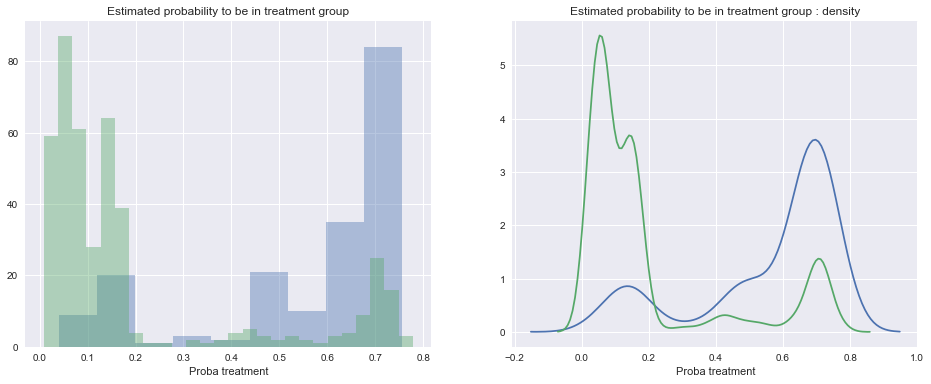

In [24]:
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 6)

plot1 = sb.distplot(df_prope_treat["Proba treatment"],kde=False, ax=plot1)
plot1 = sb.distplot(df_prope_control["Proba treatment"],kde=False, ax=plot1)
plot1.set_title("Estimated probability to be in treatment group")

plot2 = sb.distplot(df_prope_treat["Proba treatment"], hist=False,ax=plot2)
plot2 = sb.distplot(df_prope_control["Proba treatment"], hist=False,ax=plot2)
plot2.set_title("Estimated probability to be in treatment group : density")

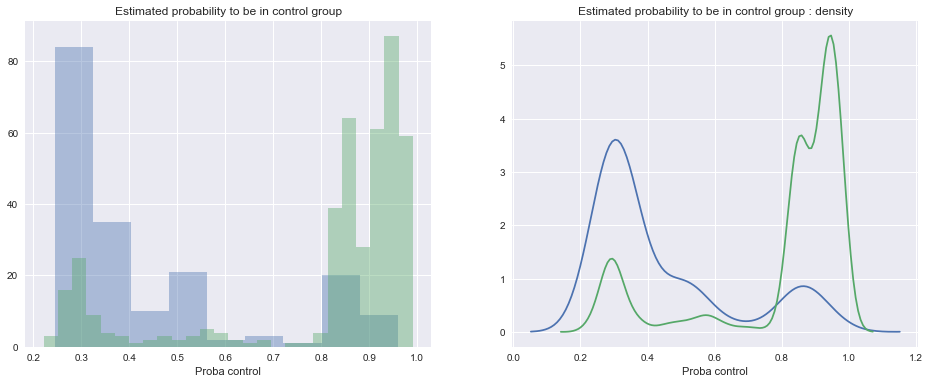

In [25]:
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 6)

plot1 = sb.distplot(df_prope_treat["Proba control"],kde=False, ax=plot1)
plot1 = sb.distplot(df_prope_control["Proba control"],kde=False, ax=plot1)
plot1.set_title("Estimated probability to be in control group")

plot2 = sb.distplot(df_prope_treat["Proba control"], hist=False,ax=plot2)
plot2 = sb.distplot(df_prope_control["Proba control"], hist=False,ax=plot2)
plot2.set_title("Estimated probability to be in control group : density")

### 4. Balancing the dataset via matching

In order to match each member of the treatment group with one person of the control group, we will use the previously calculated propensity score.
We will use the networkx package to ease our work, you will find a toy example below to explain our approach

To understand the libraby and the matching functions we made a toy example with 2 nodes in the treatment group (`t1,t2`) and 3 in the control group (`c1, c2, c3`). For each node we have attribute random values in the range [0-1] to respect the propensity score. 
Our goal is to match each node of the treatment group with a node from the control group while minimizing the difference between them, e.g. we want to minimize the sum of the absolute value of the difference of propensity score.
To use the libraby each row will be representated as a node in a bipartite graph.
We begin by computing each absolute value and add it as the weight of the edge between a treatment node and a control node. 
Then we realized that there is no function (we didn't find one) to minimize our problem but there is one to maximize it. As the function does not work with negative values and that our problem would not be correct by taking the inverse of the absolute value, we use the following formula for our weight : 
$$
w = 1 - \left| Propensity\_Score(treatment) - Propensity\_Score(control) \right|
$$

We have to notice that one node from the control group can not be matched with more than one node from the treatment group, even if the sum would have been smaller

('t1', 'c1', {'weight': 0.61})
('t1', 'c2', {'weight': 0.9})
('t1', 'c3', {'weight': 0.8})
('t2', 'c1', {'weight': 0.31000000000000005})
('t2', 'c2', {'weight': 0.8})
('t2', 'c3', {'weight': 0.5})


/opt/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/opt/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/opt/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0

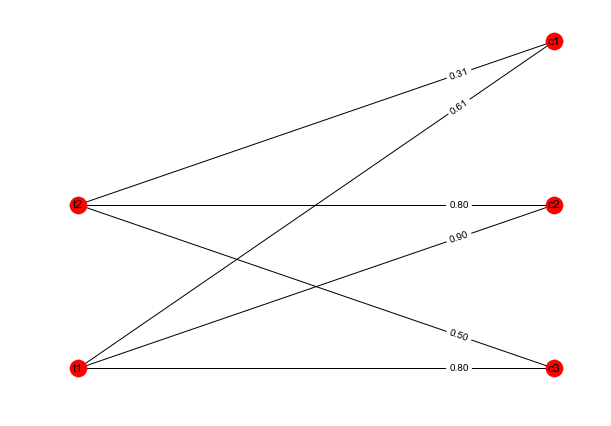

{'c2': 't2', 'c3': 't1', 't1': 'c3', 't2': 'c2'}

In [27]:
# Example:

# Define sample value
val = {'t1':0.4,'t2':0.7,'c1':0.01,'c2':0.5,'c3':0.2}
# Treatment group
t = ['t1','t2']
#Control group
c = ['c1','c2','c3']
#Create graph
g = nx.Graph()
#Add nodes to the graph
g.add_nodes_from(t, bipartite=0)
g.add_nodes_from(c, bipartite=1)
#Compute weights and add it as edges between nodes 
for i in t:
    for j in c:
        g.add_edge(i,j,weight=(1-abs(val[i]-val[j])))
for e in g.edges(data=True):
    print(e)

l,r = nx.algorithms.bipartite.sets(g)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(l) )
pos.update( (n, (2, i)) for i, n in enumerate(r) )
nx.draw(g, pos=pos,with_labels = True)
labels = nx.get_edge_attributes(g,'weight')
for k,v in labels.items():
    labels[k]=format(v, '.2f')#For readability
nx.draw_networkx_edge_labels(g,pos=pos,edge_labels=labels,label_pos=0.2)
plt.show()
nx.algorithms.matching.max_weight_matching(g)

In the example above, the graph shows the weights for all the pairs. The result below correctly returns the matching with the largest possible score (sum). Each node is matched at most once. We get the pairs `t2, c2` and `t1, c3`

In [29]:
#Luckily the id are meaningful enough to understand the output
#Long operation, be careful when running
match_graph = nx.Graph()
control_list = df_prope_control['id'].tolist()
treat_list = df_prope_treat['id'].tolist()
match_graph.add_nodes_from(df_prope_control['id'].tolist(),bipartite=0)
match_graph.add_nodes_from(df_prope_treat['id'].tolist(),bipartite=1)
#To be faster we will create a dict from the df
dict_cont = {ke:va for ke,va in zip(df_prope_control['id'],df_prope_control['Proba treatment'])}
dict_treat = {ke:va for ke,va in zip(df_prope_treat['id'],df_prope_treat['Proba treatment'])}
for treat_id in treat_list:
    for control_id in control_list:
        match_graph.add_edge(treat_id,control_id,weight=1-abs(dict_cont[control_id]-dict_treat[treat_id]))

result_edges = nx.algorithms.matching.max_weight_matching(match_graph)
result_edges

{'NSW1': 'PSID340',
 'NSW10': 'PSID40',
 'NSW100': 'PSID274',
 'NSW101': 'PSID211',
 'NSW102': 'PSID247',
 'NSW103': 'PSID213',
 'NSW104': 'PSID374',
 'NSW105': 'PSID388',
 'NSW106': 'PSID384',
 'NSW107': 'PSID127',
 'NSW108': 'PSID383',
 'NSW109': 'PSID171',
 'NSW11': 'PSID402',
 'NSW110': 'PSID217',
 'NSW111': 'PSID420',
 'NSW112': 'PSID205',
 'NSW113': 'PSID218',
 'NSW114': 'PSID159',
 'NSW115': 'PSID260',
 'NSW116': 'PSID227',
 'NSW117': 'PSID267',
 'NSW118': 'PSID188',
 'NSW119': 'PSID196',
 'NSW12': 'PSID416',
 'NSW120': 'PSID241',
 'NSW121': 'PSID355',
 'NSW122': 'PSID411',
 'NSW123': 'PSID24',
 'NSW124': 'PSID194',
 'NSW125': 'PSID103',
 'NSW126': 'PSID375',
 'NSW127': 'PSID358',
 'NSW128': 'PSID151',
 'NSW129': 'PSID313',
 'NSW13': 'PSID118',
 'NSW130': 'PSID326',
 'NSW131': 'PSID406',
 'NSW132': 'PSID423',
 'NSW133': 'PSID408',
 'NSW134': 'PSID285',
 'NSW135': 'PSID105',
 'NSW136': 'PSID252',
 'NSW137': 'PSID166',
 'NSW138': 'PSID231',
 'NSW139': 'PSID98',
 'NSW14': 'PSID41',

In [30]:
# Now we build our new control group
# First take only half of the result
new_control_id=[value for key, value in result_edges.items() if 'NSW' in key]
df_new_control = df_prope_control[df_prope_control['id'].isin(new_control_id)]
df_new_control.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Proba treatment,Proba control
189,PSID5,0,25,9,1,0,1,1,14829.6900,13776.530,0.000,0.416054,0.583946
190,PSID6,0,37,9,1,0,1,1,13685.4800,12756.050,17833.200,0.402995,0.597005
192,PSID8,0,20,12,1,0,0,0,7392.3140,12396.190,17765.230,0.765043,0.234957
199,PSID15,0,22,14,1,0,1,0,748.4399,11105.370,18208.550,0.650250,0.349750
200,PSID16,0,42,0,0,1,1,1,2797.8330,10929.920,9922.934,0.149084,0.850916
201,PSID17,0,25,9,0,1,0,1,5460.4770,10589.760,7539.361,0.168062,0.831938
208,PSID24,0,47,8,1,0,1,1,9275.1690,8543.419,0.000,0.424355,0.575645
211,PSID27,0,36,9,1,0,1,1,13256.4000,8457.484,0.000,0.354021,0.645979
215,PSID31,0,22,13,0,1,0,0,6404.8430,7882.790,9453.017,0.153226,0.846774
224,PSID40,0,40,3,0,1,1,1,7576.4850,7426.258,12104.060,0.076671,0.923329


In [31]:
df_new_control.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Proba treatment,Proba control
count,185.0,185.000000,185.000000,185.00000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.0,23.713514,10.162162,0.47027,0.118919,0.167568,0.627027,2095.885961,1615.306428,5312.474907,0.371066,0.628934
std,0.0,9.644726,2.861984,0.50047,0.324571,0.374495,0.484907,4029.201886,2674.747685,5842.884861,0.252452,0.252452
min,0.0,16.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040057,0.221902
25%,0.0,17.000000,9.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.155030,0.321448
50%,0.0,19.000000,10.000000,0.00000,0.000000,0.000000,1.000000,289.971500,451.161300,3392.860000,0.183744,0.816256
75%,0.0,26.000000,12.000000,1.00000,0.000000,0.000000,1.000000,2068.986000,1890.581000,7933.914000,0.678552,0.844970
max,0.0,55.000000,18.000000,1.00000,1.000000,1.000000,1.000000,21918.320000,13776.530000,20243.380000,0.778098,0.959943


We can notice a lower value for both the median and the mean for all the earnings columns, and that the `re78` column is "worse" than in the treatment group

In [32]:
#To reuse some previous code we will concatenate both
df_new_total = pd.concat([df_new_control,df_prope_treat])
df_new_total.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Proba treatment,Proba control
189,PSID5,0,25,9,1,0,1,1,14829.6900,13776.530,0.000,0.416054,0.583946
190,PSID6,0,37,9,1,0,1,1,13685.4800,12756.050,17833.200,0.402995,0.597005
192,PSID8,0,20,12,1,0,0,0,7392.3140,12396.190,17765.230,0.765043,0.234957
199,PSID15,0,22,14,1,0,1,0,748.4399,11105.370,18208.550,0.650250,0.349750
200,PSID16,0,42,0,0,1,1,1,2797.8330,10929.920,9922.934,0.149084,0.850916
201,PSID17,0,25,9,0,1,0,1,5460.4770,10589.760,7539.361,0.168062,0.831938
208,PSID24,0,47,8,1,0,1,1,9275.1690,8543.419,0.000,0.424355,0.575645
211,PSID27,0,36,9,1,0,1,1,13256.4000,8457.484,0.000,0.354021,0.645979
215,PSID31,0,22,13,0,1,0,0,6404.8430,7882.790,9453.017,0.153226,0.846774
224,PSID40,0,40,3,0,1,1,1,7576.4850,7426.258,12104.060,0.076671,0.923329


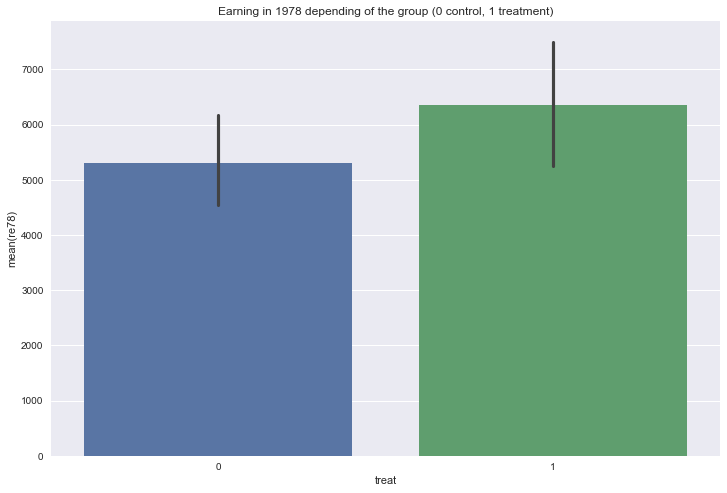

In [33]:
zone, plot = plt.subplots(ncols=1, sharey=True)
zone.set_size_inches(12, 8)
plot = sb.barplot(x="treat", y="re78", data=df_new_total.sort_values(["treat"],ascending=True))
plot.set_title("Earning in 1978 depending of the group (0 control, 1 treatment)")

This time the treated group is better than the control group

In order to preserve the readability of our document, we won't show again all the plots from question 1.2 for each non categorical values.

In [34]:
def add_essential(column,desc,dftot,dfc,dft):
    m_treated = dft[column].mean()
    m_control = dfc[column].mean()
    print(f'Mean for treated group : {m_treated}')
    print(f'Mean for control group : {m_control}')
    print(f'Difference of mean (this time treated - control ) : {m_treated-m_control}')
    zone, (plot1, plot2) = plt.subplots(ncols=2)
    zone.set_size_inches(16, 6)
    
    plot1 = sb.boxplot(y = column ,x="treat", data=dftot, ax = plot1, showfliers=False)
    plot1.set_title(desc+" based on the group")

    plot2 = sb.distplot(dfc[column],ax=plot2)
    plot2 = sb.distplot(dft[column], ax=plot2)
    plot2.set_title(desc+" based on the group")
    print("Control group is blue and treated group is green")

**Age**

Mean for treated group : 25.816216216216215
Mean for control group : 23.713513513513515
Difference of mean (this time treated - control ) : 2.1027027027027003
Control group is blue and treated group is green


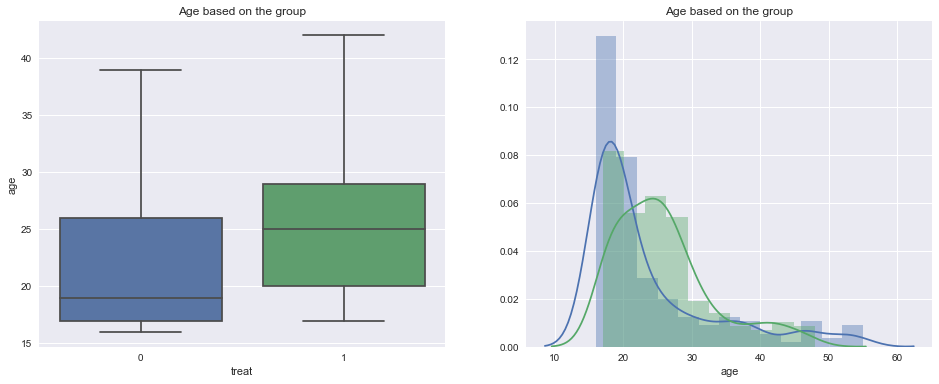

In [35]:
add_essential("age","Age",df_new_total,df_new_control,df_prope_treat)

**Education**

Mean for treated group : 10.345945945945946
Mean for control group : 10.162162162162161
Difference of mean (this time treated - control ) : 0.18378378378378457
Control group is blue and treated group is green


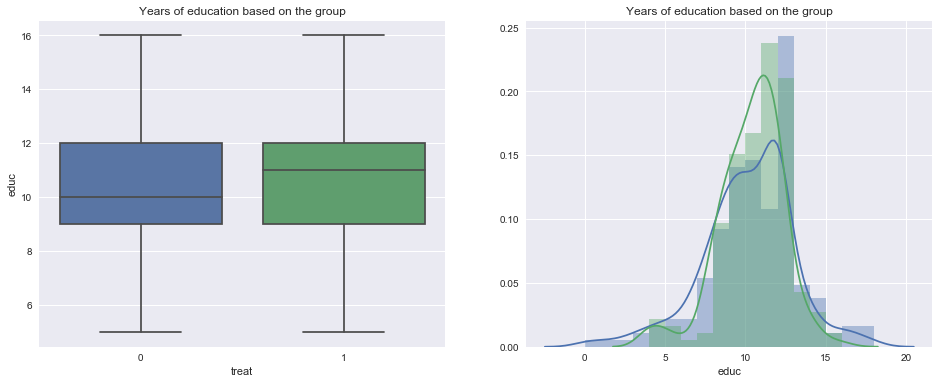

In [36]:
add_essential("educ","Years of education",df_new_total,df_new_control,df_prope_treat)

**Earnings in 74**

Mean for treated group : 2095.573688648649
Mean for control group : 2095.8859610270283
Difference of mean (this time treated - control ) : -0.3122723783794754
Control group is blue and treated group is green


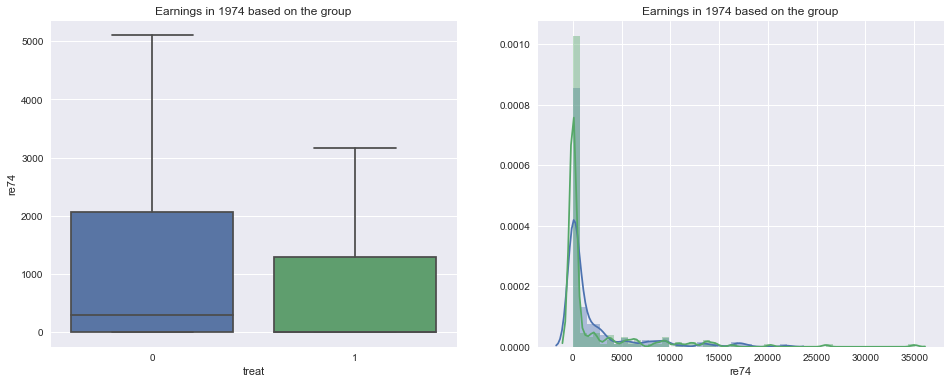

In [37]:
add_essential('re74',"Earnings in 1974",df_new_total,df_new_control,df_prope_treat)

**Earnings in 75**

Mean for treated group : 1532.055313783784
Mean for control group : 1615.306428108107
Difference of mean (this time treated - control ) : -83.251114324323
Control group is blue and treated group is green


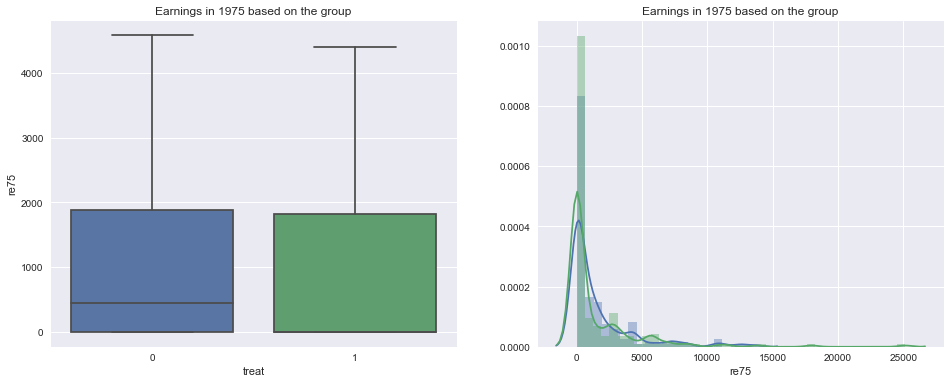

In [38]:
add_essential('re75',"Earnings in 1975",df_new_total,df_new_control,df_prope_treat)

In [39]:
population_treated=df_prope_treat.shape[0]
population_control=df_new_control.shape[0]
df_categorical = get_categorical_results(df_new_total,population_treated,population_control)
df_categorical

Total number of Black people : 243
Number of Black people in the treatment group : 156, which represents 84.32432432432432% of the treated group
Number of Black people in the control group : 87, which represents 47.027027027027025% of the control group

Total number of Hispanic people : 33
Number of Hispanic people in the treatment group : 11, which represents 5.945945945945946% of the treated group
Number of Hispanic people in the control group : 22, which represents 11.891891891891891% of the control group

Total number of White people : 94
Number of White people in the treatment group : 18, which represents 9.72972972972973% of the treated group
Number of White people in the control group : 76, which represents 41.08108108108108% of the control group

Total number of Married people : 66
Number of Married people in the treatment group : 35, which represents 18.91891891891892% of the treated group
Number of Married people in the control group : 31, which represents 16.756756756756758%

,Feature,Percentage treatment,Percentage control
0,black,84.324324,47.027027
1,hispan,5.945946,11.891892
2,white,9.729730,41.081081
3,married,18.918919,16.756757
4,nodegree,70.810811,62.702703


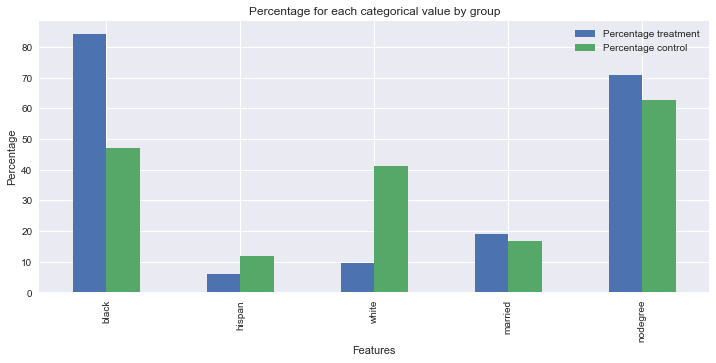

In [40]:
plot = df_categorical.plot.bar(y=["Percentage treatment","Percentage control"],x=["Feature"], figsize=(12,5))
plot.set_xlabel('Features');
plot.set_ylabel('Percentage');
plot.set_title('Percentage for each categorical value by group');

Globally our new control group is closer to our treatment group even it remains some difference, here is a quick analysis for each property : 
* Age : People from the treatment group are older than those in the control group, but the gap is reasonnable
* Years of education : The values are really close in both groups
* Earnings in 74 : earnings are close but are bigger in the control group. There are less big outliers in the control group than before, the mean is lower
* Earnings in 75 : both groups are really close and there are no concrete difference
* Black people : The diffenrece remains really different between groups
* Hispanic and married people : There are still small differences but there are really smaller than before
* White people: we still have a clear difference
* No degree : The difference is small, but there is still a gap

If we look at the criteria for which our models has really decreased the gap, we can notice that they are probably those that seems the more impactful for a human being too : earnings are closer, education too.

This shorter distance between both groups allow us to analysis the difference of mean for the `re78` category with more confidence. This time we can see that earnings are noticeably higher for the treatment group, this may prove the efiiciency of this treatment.

### 5. Balancing the groups further

While we are closer to  perfectly balanced groups, it's still not enough to be sure to draw valid conclusions.
Thus we will try to improve our matching while keeping enough people in each group.
We will procede as follow :
* We compute a new weight for each edge
* We recompute our matching
* We keep only nodes with a good enough score

To compute our new score, we have thought that categorical data are really the most important thing to have in common,
thus our new weight is 0 or 1 for each feature that is categorical : 
* For `black, hispan, married, nodegree` we just take 1 minus the absolute value of the difference. If they share the feature, difference will be 0 so the associated weight is 1 (we want to maximise our sum)
* For `age`, we consider that the age is similar (weight 1) if the difference if less than 5
* For `educ`, we condider that the education is similar if the difference is less than 2, this is probably the stronger assumption we made
We also decided that the values `re74` and `re75` did not need to be improved, we will however check that the results are still good enough.

In [44]:
match_graph_b = nx.Graph()
control_list = df_prope_control['id'].tolist()
treat_list = df_prope_treat['id'].tolist()
match_graph_b.add_nodes_from(df_prope_control['id'].tolist(),bipartite=0)
match_graph_b.add_nodes_from(df_prope_treat['id'].tolist(),bipartite=1)
for treat_id in treat_list:
    valTreat = df_prope_treat[df_prope_treat["id"]==treat_id]
    for control_id in control_list:
        valControl = df_prope_control[df_prope_control["id"]==control_id]
        weight = 1-abs(float(valTreat["Proba treatment"])-float(valControl["Proba treatment"]))
        weight+= 0 if abs(int(valTreat["age"])-int(valControl["age"]))>5 else 1
        weight+= 0 if abs(float(valTreat["educ"])-float(valControl["educ"]))>2 else 1
        weight+= 1 - abs(int(valTreat["black"])-int(valControl["black"]))
        weight+= 1 - abs(int(valTreat["hispan"])-int(valControl["hispan"]))
        weight+= 1 - abs(int(valTreat["married"])-int(valControl["married"]))
        weight+= 1 - abs(int(valTreat["nodegree"])-int(valControl["nodegree"]))
        #weight+= 0 if abs(int(valTreat["re74"])-int(valControl["re74"]))>1000 else 1
        #weight+= 0 if abs(int(valTreat["re75"])-int(valControl["re75"]))>1000 else 1
        match_graph_b.add_edge(treat_id,control_id,weight=weight)

result_edges_b = nx.algorithms.matching.max_weight_matching(match_graph_b)
result_edges_b

{'NSW1': 'PSID368',
 'NSW10': 'PSID144',
 'NSW100': 'PSID199',
 'NSW101': 'PSID388',
 'NSW102': 'PSID253',
 'NSW103': 'PSID156',
 'NSW104': 'PSID374',
 'NSW105': 'PSID184',
 'NSW106': 'PSID272',
 'NSW107': 'PSID15',
 'NSW108': 'PSID252',
 'NSW109': 'PSID323',
 'NSW11': 'PSID187',
 'NSW110': 'PSID238',
 'NSW111': 'PSID208',
 'NSW112': 'PSID240',
 'NSW113': 'PSID335',
 'NSW114': 'PSID397',
 'NSW115': 'PSID41',
 'NSW116': 'PSID332',
 'NSW117': 'PSID407',
 'NSW118': 'PSID8',
 'NSW119': 'PSID196',
 'NSW12': 'PSID337',
 'NSW120': 'PSID151',
 'NSW121': 'PSID217',
 'NSW122': 'PSID402',
 'NSW123': 'PSID429',
 'NSW124': 'PSID7',
 'NSW125': 'PSID325',
 'NSW126': 'PSID26',
 'NSW127': 'PSID206',
 'NSW128': 'PSID331',
 'NSW129': 'PSID76',
 'NSW13': 'PSID218',
 'NSW130': 'PSID209',
 'NSW131': 'PSID406',
 'NSW132': 'PSID423',
 'NSW133': 'PSID308',
 'NSW134': 'PSID185',
 'NSW135': 'PSID46',
 'NSW136': 'PSID281',
 'NSW137': 'PSID212',
 'NSW138': 'PSID422',
 'NSW139': 'PSID424',
 'NSW14': 'PSID235',
 'NS

In [45]:
filtered_result = {}
for e in match_graph_b.edges(data=True):
    if result_edges_b[e[1]] == e[0]:
        if(e[2]["weight"])>=6.9:
            filtered_result[e[1]]=e[0]
print(len(filtered_result))

93


We keep only weight greater than 6.9, which corresponds to all considered features equals and less than 0,1 in propensity score differense. We still have 93 members in our dataset, which is enough to represent our treatment efficiency.

We know that we can't match the whole treatement group because there is not enough black people in the control group. Therefore we can match about 100 people.

```
Total number of Black people : 243
Number of Black people in the treatment group : 156, which represents 84.32432432432432% of the treated group
Number of Black people in the control group : 87, which represents 20.27972027972028% of the control group
```

In [46]:
new_new_control_id=[value for key, value in filtered_result.items()]
df_new_new_control = df_prope_control[df_prope_control['id'].isin(new_new_control_id)]
df_new_new_control.head(5)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Proba treatment,Proba control
189,PSID5,0,25,9,1,0,1,1,14829.690,13776.53,0.000,0.416054,0.583946
190,PSID6,0,37,9,1,0,1,1,13685.480,12756.05,17833.200,0.402995,0.597005
191,PSID7,0,32,12,0,0,1,0,19067.580,12625.35,14146.280,0.039388,0.960612
192,PSID8,0,20,12,1,0,0,0,7392.314,12396.19,17765.230,0.765043,0.234957
201,PSID17,0,25,9,0,1,0,1,5460.477,10589.76,7539.361,0.168062,0.831938


In [47]:
new_new_treat_id=[key for key, value in filtered_result.items()]
df_new_new_treat = df_prope_treat[df_prope_treat['id'].isin(new_new_treat_id)]
df_new_new_treat.head(5)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Proba treatment,Proba control
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350,0.556650
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660,0.855340
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355,0.277645
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286,0.301714
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0.731792,0.268208


In [48]:
df_nnt = pd.concat([df_new_new_control,df_new_new_treat])
df_nnt.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Proba treatment,Proba control
189,PSID5,0,25,9,1,0,1,1,14829.690,13776.530,0.000,0.416054,0.583946
190,PSID6,0,37,9,1,0,1,1,13685.480,12756.050,17833.200,0.402995,0.597005
191,PSID7,0,32,12,0,0,1,0,19067.580,12625.350,14146.280,0.039388,0.960612
192,PSID8,0,20,12,1,0,0,0,7392.314,12396.190,17765.230,0.765043,0.234957
201,PSID17,0,25,9,0,1,0,1,5460.477,10589.760,7539.361,0.168062,0.831938
208,PSID24,0,47,8,1,0,1,1,9275.169,8543.419,0.000,0.424355,0.575645
211,PSID27,0,36,9,1,0,1,1,13256.400,8457.484,0.000,0.354021,0.645979
225,PSID41,0,22,12,1,0,1,0,9729.719,7372.548,2231.367,0.465022,0.534978
243,PSID59,0,36,12,1,0,1,0,11040.470,6221.371,7215.739,0.401214,0.598786
260,PSID76,0,26,12,0,1,0,0,7968.338,5109.581,4181.966,0.124738,0.875262


In [49]:
population_treated=df_new_new_treat.shape[0]
population_control=df_new_new_control.shape[0]
df_categorical = get_categorical_results(df_nnt,population_treated,population_control)
df_categorical

Total number of Black people : 128
Number of Black people in the treatment group : 64, which represents 68.81720430107526% of the treated group
Number of Black people in the control group : 64, which represents 68.81720430107526% of the control group

Total number of Hispanic people : 22
Number of Hispanic people in the treatment group : 11, which represents 11.827956989247312% of the treated group
Number of Hispanic people in the control group : 11, which represents 11.827956989247312% of the control group

Total number of White people : 36
Number of White people in the treatment group : 18, which represents 19.35483870967742% of the treated group
Number of White people in the control group : 18, which represents 19.35483870967742% of the control group

Total number of Married people : 38
Number of Married people in the treatment group : 19, which represents 20.43010752688172% of the treated group
Number of Married people in the control group : 19, which represents 20.43010752688172% 

,Feature,Percentage treatment,Percentage control
0,black,68.817204,68.817204
1,hispan,11.827957,11.827957
2,white,19.354839,19.354839
3,married,20.430108,20.430108
4,nodegree,67.741935,67.741935


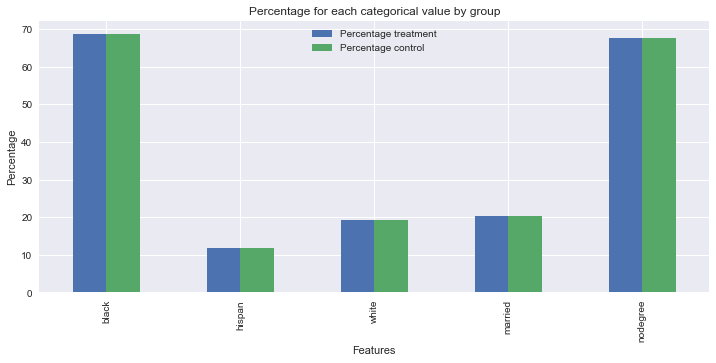

In [50]:
plot = df_categorical.plot.bar(y=["Percentage treatment","Percentage control"],x=["Feature"], figsize=(12,5))
plot.set_xlabel('Features');
plot.set_ylabel('Percentage');
plot.set_title('Percentage for each categorical value by group');

In [51]:
def comparePlots(column,desc,dfca,dfta,dfcb,dftb):
    zone, (plot1, plot2) = plt.subplots(ncols=2)
    zone.set_size_inches(16, 6)
    
    plot1 = sb.distplot(dfca[column],ax=plot1)
    plot1 = sb.distplot(dfta[column], ax=plot1)
    plot1.set_title(desc+" based on the group,Old split")

    plot2 = sb.distplot(dfcb[column],ax=plot2)
    plot2 = sb.distplot(dftb[column], ax=plot2)
    plot2.set_title(desc+" based on the group, New split")
    print("Control group is blue and treated group is green")
    print("Left is before, right after")

**Age**

Control group is blue and treated group is green
Left is before, right after


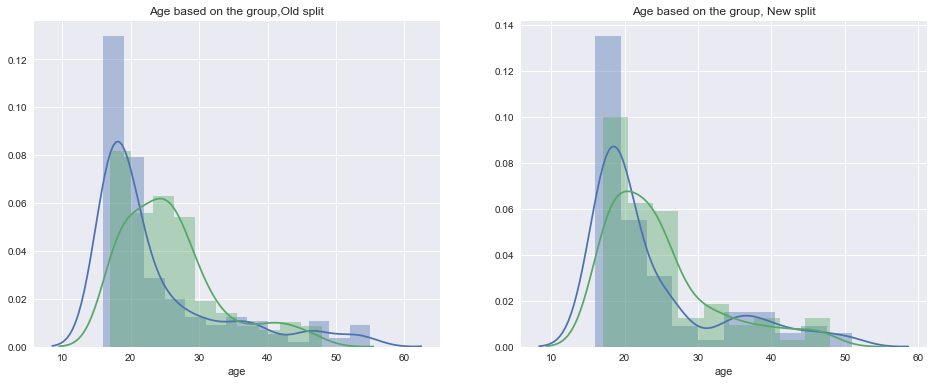

In [52]:
comparePlots("age","Age",df_new_control,df_prope_treat,df_new_new_control,df_new_new_treat)

**Years of education**

Control group is blue and treated group is green
Left is before, right after


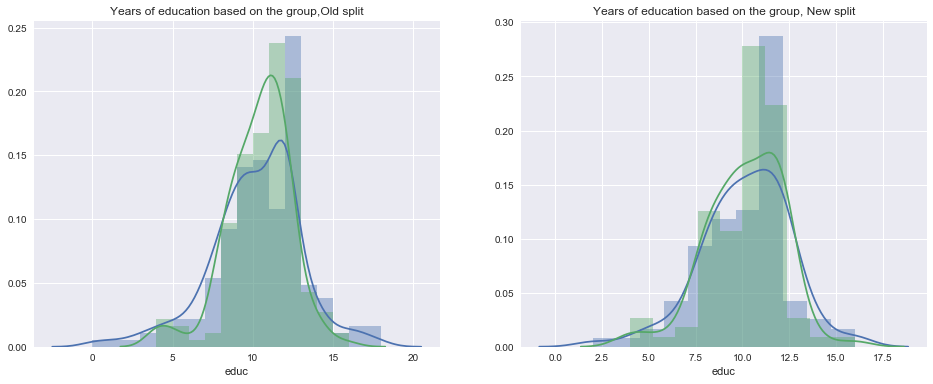

In [53]:
comparePlots("educ","Years of education",df_new_control,df_prope_treat,df_new_new_control,df_new_new_treat)

**Earnings in 74**

Control group is blue and treated group is green
Left is before, right after


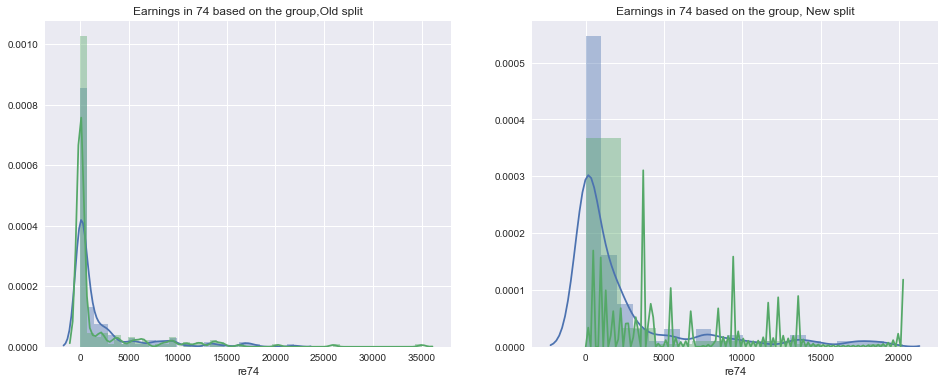

In [54]:
comparePlots("re74","Earnings in 74",df_new_control,df_prope_treat,df_new_new_control,df_new_new_treat)

*Note that even if the density looks a bit strange on our new split, we can notice that most of earnings are very low and similar*

**Earnings in 75**

Control group is blue and treated group is green
Left is before, right after


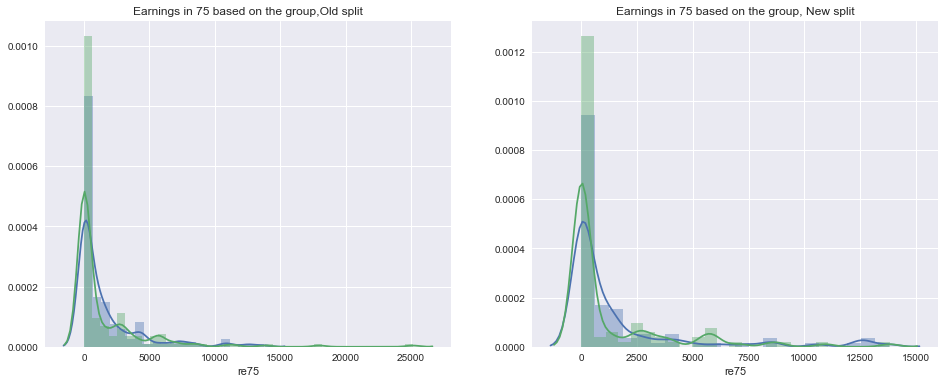

In [55]:
comparePlots("re75","Earnings in 75",df_new_control,df_prope_treat,df_new_new_control,df_new_new_treat)

We matched perfectly the categorical data so it is obviously a stronger base for conclusion than before. 
With the plots for continous values it seems than our results are better too, except maybe for earnings in 74.
With these 2 datasets we should be able to conclude about the treatment without a too big risk

### 6. A less naive analysis

With our new control and treatment groups, we are more likely to draw a valid conclusion about the real efficiency of the studied program.

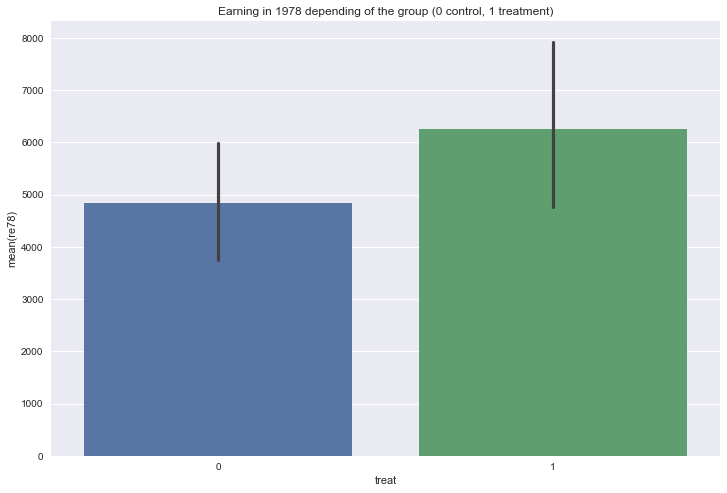

In [56]:
zone, plot = plt.subplots(ncols=1, sharey=True)
zone.set_size_inches(12, 8)
plot = sb.barplot(x="treat", y="re78", data=df_nnt.sort_values(["treat"],ascending=True))
plot.set_title("Earning in 1978 depending of the group (0 control, 1 treatment)")

It seems that the earning in 1978 is higher (as a mean) that in the control group, however the mean slightly overlap the deviation. There is more than 1000$ difference between both of them, meaning a non insignificant difference.

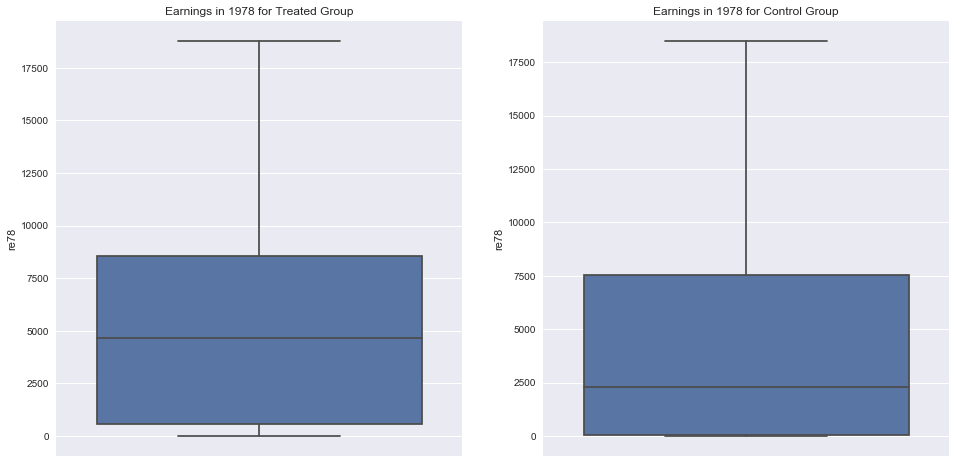

In [57]:
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 8)

plot1 = sb.boxplot(y = 're78' , data=df_new_new_treat, ax = plot1,showfliers=False)
plot1.set_title("Earnings in 1978 for Treated Group")

plot2 = sb.boxplot(y = 're78' , data=df_new_new_control, ax = plot2,showfliers=False)
plot2.set_title("Earnings in 1978 for Control Group")

The median value for treated group is clearly higher in the treated group than in the control group, we can also notice thant more than 25% of people in treated group is not unemployed (earnings are greater than 0)

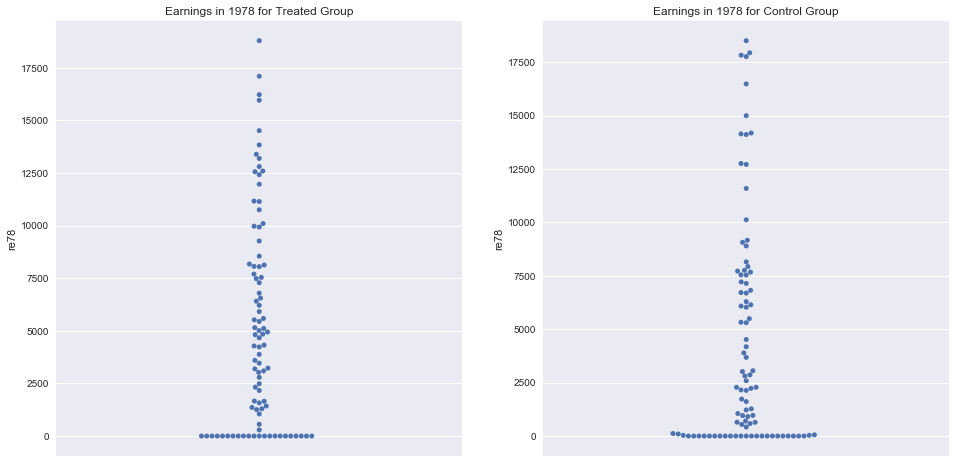

In [58]:
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 8)

plot1 = sb.swarmplot(y = 're78' , data=df_new_new_treat[df_new_new_treat['re78']<20000], ax = plot1)
plot1.set_title("Earnings in 1978 for Treated Group")

plot2 = sb.swarmplot(y = 're78' , data=df_new_new_control[df_new_new_control['re78']<20000], ax = plot2)
plot2.set_title("Earnings in 1978 for Control Group")

In the previous plots, we removed a few outliers iin order to have similar scales in both plots (remove earnings greater than 20 000). Beause we know have the same population we can see than there is more people with (close to) zero earning in our control group.

## Question 2

In this part, we will study the [20 newsgroups dataset](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)
and train a classifier.
The dataset contains emails from 20 different news groups. Our goal is to train a classifier able to assign the the most likely newsgroup to each email by analyzing its content.

We will first download the dataset and take a look at the available data. Then, we will train multiple random forest classifiers. Each of them will have different hyper parameters. We will then select the hyperparameters and classifier leading to the best score according to cross-validation on a subset of our data.
Finally, we will validate the classifier on 10% of the data that we kept on the side and analyse the results we obtain.

**Note**: Some of the cells are expensive to execute (they have a warning). Training some models may take a few ours and consume a few gigabytes of memory. Due to their cost on resources, this notebook was executed in multiple step (execute, save the results, restart the kernel).

In [59]:
# Import dependencies for part 2
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from email.parser import Parser as EmailParser
import sklearn
import pandas
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
# Download the training dataset to `~/scikit_learn_data/20news_home` then load it to a variable
newsgroups = fetch_20newsgroups(subset='train')

## Dataset description

[Official description](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)

In [61]:
# Check the available keys
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

The loaded data contains the following properties:

- `data`: List of 11314 strings representing the messages.
- `filenames`: Absolute path to the downloaded file containing the message (11314 items).
- `target_names`: List of the names of the 20 newsgroups:
  ```
  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
  ```
- `target`: List of ids for the targets: from 0 to 19 referencing the targets defined in `target_names`.
- `DESCR`: No value (`None`)
- `description`: String describing the dataset: `'the 20 newsgroups by date dataset'`

The messsages are formatted as emails: they have a header followed by a blank line and then the body with the actual text content. 
For example, you can view the message with the id `0` below.

Here are some observations:
- The most common header seem to be `From`, `Subject`, `Organization` and `Lines` 
- Messages `754`, `8000` and others have quotes
- Message `1704` seems to have an attachment (or manually pasted source code)

In [62]:
# Set the message id to view specific messages
msg_id = 0
print(f"Category: {newsgroups.target_names[newsgroups.target[msg_id]]}\n")
print(newsgroups.data[msg_id])

Category: rec.autos

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







## Dataframe

We will clean the data and place them in a dataframe to have them easily available.

The goal of cleaning the data is to avoid the classifier to use informations such as headers (author, organization...), signatures or quotes to classify the data. Instead we want it to use the text content of the body of the message.

We use the the `_raw` suffix for the original email, `_clean` for the one without any quotes, headers and footers. (The base value is the email without its headers)

In [63]:
# Use the builtin function to clean the mails
newsgroups_clean = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [74]:
# Here is an example of filtered email, you can compare it with the original mail a few cells above.
newsgroups_clean.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [64]:
def read_header_or_none(headers, name):
    """
    Tries to read the header `name` from `headers`, else returns `None`.
    """
    if name in headers:
        return headers[name]
    return None

In [65]:
def create_entry(label, label_id, subject, body, from_, organization, raw, clean):
    return {
        "label": label,
        "label_id": label_id,
        "subject": subject,
        "body": body,
        "from": from_,
        "organization": organization,
        "raw": raw,
        "clean": clean
    }

In [66]:
def create_df(emails, cleaned_emails, labels, label_ids):
    email_parser = EmailParser()
    entries = []
    for email, cleaned_email, label_id in zip(emails, cleaned_emails, label_ids):
        label = labels[label_id]
        parsed_email = email_parser.parsestr(email, headersonly=False)
        body = parsed_email.get_payload()
        headers = dict(parsed_email.items())
        subject = read_header_or_none(headers, "Subject")
        from_ = read_header_or_none(headers, "From")
        organization = read_header_or_none(headers, "Organization")
        entry = create_entry(label, label_id, subject, body, from_, organization, email, cleaned_email)
        entries.append(entry)
    return pandas.DataFrame(entries)

In [67]:
# Create the dataframe
news_df = create_df(newsgroups.data, newsgroups_clean.data, newsgroups.target_names, newsgroups.target)
news_df.head(5)

Regarding the different kinds of emails we have (`raw`, `body` and `clean`), it seems that the builtin clean function is a bit too eager:

In [71]:
(news_df["clean"] == "").sum()

218

In [72]:
(news_df["raw"] == "").sum()

0

We see that it 218 mails (about 2%) are completely cleaned.
We will still focus on the cleaned version to train the data because we want to target the content, but we will compare it to the version with the raw and body (raw without headers) versions later.

## Classifier training

In [80]:
def create_permutation(n: int, rand_state = None):
    """
    Create a ranom permutation of size `n`.
    
    :param n: Size of the permutation
    :param rand_state: Random state to use to create the permutation.
    :return: A 1D numpy ndarray of size. It contains a permutation of integers from 0 to n-1
    """
    if rand_state is None:
        rand_state = numpy.random.RandomState()
    return rand_state.permutation(n)

In [81]:
def split_data(features, labels, ratios, rand_state = None):
    """
    Pseudo-randomly splits a dataset into smaller datasets of the provided size.
    
    This is is similar to `sklearn.model_selection.train_test_split` but allows
    to split the data into more than two sets and returns the original indexes.
    
    :param features: Numpy array of features
    :param labels: Numpy array of labels
    :param ratios: List of sizes of the first n-1 groups expressed as ratios of
                   the total size. The last group will have the remaining items.
    :param rand_state: Random state used to create the permutation
    :return: A list of groups of tuples (old_indexes, features, labels)
    """
    from math import floor
    if rand_state is None:
        rand_state = numpy.random.RandomState()
    
    row_count = features.shape[0]
    permutation = create_permutation(row_count, rand_state)
    
    
    split_indexes = [0]
    cur_ratio = 0
    for ratio in ratios:
        cur_ratio += ratio
        split_index = floor(cur_ratio * row_count)
        split_indexes.append(split_index)
    split_indexes.append(row_count)
    
    result = []
    for i in range(len(split_indexes) - 1):
        start_index = split_indexes[i]
        end_index = split_indexes[i + 1]
        old_indexes = permutation[start_index:end_index]
        cur_features = features[old_indexes]
        cur_labels = labels[old_indexes]
        result.append((old_indexes, cur_features, cur_labels))
    
    return result

In [82]:
def evaluate_parameters(n_estimators, max_depth, features, labels, rounds=3):
    """
    Get the score and classifier for the a model using random forests with the hyper parameters
    `n_estimators` and `max_depth` cross-validated with `features` and `labels`.
    
    The cross validation is repeated `rounds` times and the result is the median value.
    For each round, 10% of the original dataset is used for tests, the remaining for training.
    These test and train datasets are selected randomly for each round.
    
    The goal of randomizing the rounds and returning the median is to reduce overfitting.
    """
    evaluated = []
    for _ in range(rounds):
        (test, train) = split_data(features, labels, [0.1 / 0.9])
        _, test_features, test_labels = test
        _, train_features, train_labels = train

        classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        trained_classifier = classifier.fit(train_features, train_labels)
        predicted_test_labels = trained_classifier.predict(test_features)
        unique_labels = numpy.unique(predicted_test_labels)
        score = sklearn.metrics.f1_score(test_labels, predicted_test_labels, average='macro', labels=unique_labels)
        evaluated.append((score, trained_classifier))

    return sorted(evaluated)[rounds // 2] # return median

In [88]:
def grid_search(n_estimators_values, max_depth_values, features, labels):
    """
    Performs a grid search on the hyperparameters `n_estimators` and `max_depth` to find the best classifier.
    
    This is similar to `sklearn.model_selection.GridSearchCV`.
    
    Provide the values to search as ranges. The values must be strictly positive integers
    for both hyperparameters.
    The functions returns a dictionary with the keys:
    - params: Combination of parameters leading to the highest score
    - score: Highest score achieved
    """
    from ipywidgets import FloatProgress
    from IPython.display import display
    
    # Display a progress bar since the computation can take some time
    params_count = len(n_estimators_values) * len(max_depth_values)
    progress_bar = FloatProgress(min=0, max=params_count)
    display(progress_bar)
    
    result = None
    cur_param = 0
    for n_estimators in n_estimators_values:
        for max_depth in max_depth_values:
            progress_bar.value = cur_param
            score, classifier = evaluate_parameters(n_estimators, max_depth, features, labels)
            if result is None or score > result["score"]:
                result = {"score": score, "params": (n_estimators, max_depth), "classifier": classifier}
            cur_param += 1
    progress_bar.value = params_count
    return result


In [89]:
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(news_df["clean"])
labels = numpy.array(news_df["label_id"])

In [90]:
features.shape

(11314, 101631)

Out of our 11 thousand emails, we found about 100k features.

In [91]:
# Split the data: keep 10% on the side for final validation and 90% for training.
(validate, test_train) = split_data(features, labels, [0.1])

First hyperparameter search.

We will use the [Renard series](https://en.wikipedia.org/wiki/Renard_series) that are standard logarithm series to get a rough estimation of the magnitude of the hyperparameters so we'll be able to then do a finer search.

The `n_estimators` is the number of trees in our forest while `max_depth` is their size. We expect a relatively small size for the tree but a large value for the number of estimators.

**WARNING: THIS OPERATION IS COMPUTATIONALLY EXPENSIVE!!!**

In [92]:
renard_serie5 = [1, 2, 4, 6, 10, 16, 25, 40, 63, 100, 160, 250, 400, 630]

# Can take a few hours and a few GB of RAM.
rough_best = grid_search(renard_serie5, renard_serie5, test_train[1], test_train[2])

In [93]:
# Display the best hyperparameters we found with its score (obtained with cross validation on 90% of the data)
rough_best

{'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=40, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=630, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False),
 'params': (630, 40),
 'score': 0.63078739446813592}

We will now apply the classifier to the validation dataset.

In [95]:
_, validate_features, validate_labels = validate
predicted_validate_labels =  rough_best["classifier"].predict(validate_features)
sklearn.metrics.f1_score(validate_labels, predicted_validate_labels, average='macro')

0.61659842564826162

It seems that the best parameters are around `40` for the size of the tree but we found a number of classifiers of `630`: our maximum value.

To get finer values, we will focus on values around `40` for the max depth and use higher values for the number of trees.

We also noticed that we slightly overfitted our training data: the score on the validation set is worse.

**WARNING: The next cell is computationally expensive**

In [100]:
# Split the data: keep 10% on the side for final validation and 90% for training.
(validate2, test_train2) = split_data(features, labels, [0.1])
small_renard_serie20 = [25, 28, 31, 35, 40, 45, 50, 56, 63]
large_renard_serie20 = [560, 630, 800, 1000, 1250, 1400, 1600]
# Can take a few hours and 5-6GB of RAM.
finer_best = grid_search(large_renard_serie20, small_renard_serie20, test_train[1], test_train[2])
finer_best

{'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=50, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1400, n_jobs=1, oob_score=False,
             random_state=None, verbose=0, warm_start=False),
 'params': (1400, 50),
 'score': 0.65588154694335365}

We get a finer classifier: it uses `1400` trees and a depth of `50`.
Despite more than doubling the number of trees, the training score only increased by about 5% for this classifier.

In [102]:
best_classifier = finer_best["classifier"]

In [103]:
validate_old_indexes2, validate_features2, validate_labels2 = validate2
predicted_validate_labels2 =  best_classifier.predict(validate_features2)
sklearn.metrics.f1_score(validate_labels2, predicted_validate_labels2, average='macro')

0.89754530461078086

We get a way better score on our validation dataset by increasing the number of trees.
Trying higher values does not seems to improve the results enough (and it is already pretty long to compute).

## Classifier analysis

The first thing we can do to better understand our classifier is to plot its confusion matrix.

It displays the predicted newsgroups against the real newgroups

In [104]:
confusion_matrix = sklearn.metrics.confusion_matrix(validate_labels2, predicted_validate_labels2)

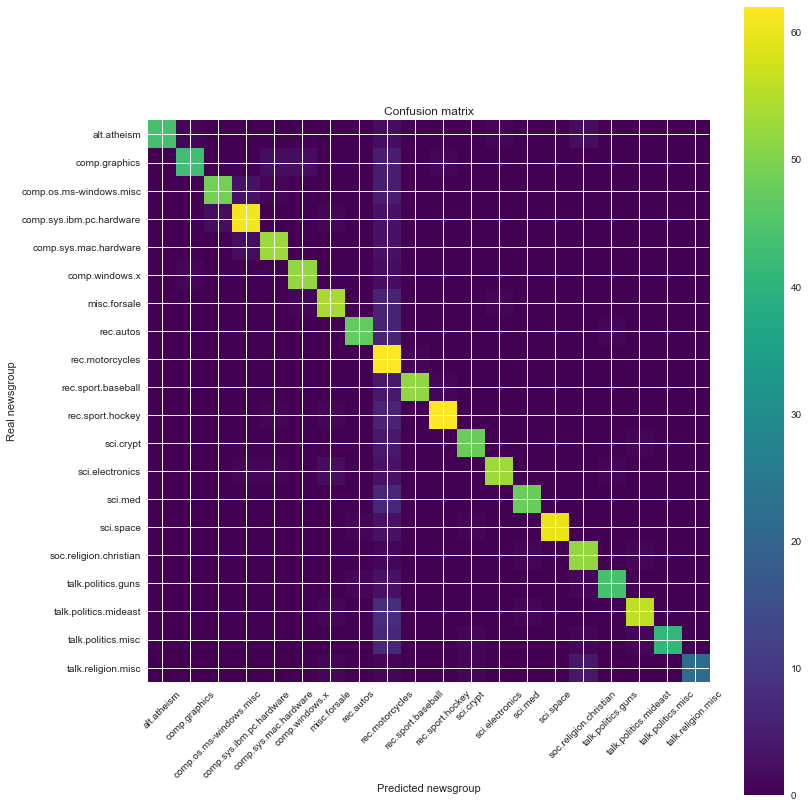

In [106]:
plt.figure(figsize=(12,12))
figure = plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.viridis)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = numpy.arange(len(newsgroups.target_names))
plt.xticks(tick_marks, newsgroups.target_names, rotation=45)
plt.yticks(tick_marks, newsgroups.target_names)
plt.ylabel('Real newsgroup')
plt.xlabel('Predicted newsgroup')
plt.tight_layout()